# Model building: Random Forest and XGBoost

Tree-based models such as Random Forest and XGBoost often give better performance than simpler models. These models are good for tuning because you can tune in hyperparamterers, such as tree-depth, max leaf node etc.

Tree-based models (Random Forest, XGBoost, Decision Trees) are scale-invariant, because they split features based on thresholds rather than distances. Scaling or standardizing the numbers won’t change the splits or the model’s predictions. The only preprocessing you still need is handling categorical features (e.g., one-hot encoding or ordinal encoding), because these models in scikit-learn can’t work directly with strings.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [6]:
anxiety_data = pd.read_csv("enhanced_anxiety_dataset.csv")
anxiety_data.head()

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


First, I will one-hot encode categorical features. Scaling numerical features is unecessary, because for tree-based models the data is split according to the calculated treshold.

In [21]:
# prepare prediction and target features
X = anxiety_data.drop(columns = ['Anxiety Level (1-10)'])
y = anxiety_data[['Anxiety Level (1-10)']]

# split the data into training and test set (80% train_valid, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# select column types on the training set
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# one-hot encode categorical columns (like in the feature engineering stage)
OH_encoder = OneHotEncoder(drop='first', sparse_output=False) 

OH_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols]),
                        columns=OH_encoder.get_feature_names_out(categorical_cols),
                        index=X_train.index)

OH_test = pd.DataFrame(OH_encoder.transform(X_test[categorical_cols]),
                       columns=OH_encoder.get_feature_names_out(categorical_cols),
                       index=X_test.index)


# drop original categorical columns and add the one-hot encoded columns instead
X_train_final = pd.concat([X_train.drop(columns=categorical_cols), OH_train], axis=1)
X_test_final = pd.concat([X_test.drop(columns=categorical_cols), OH_test], axis=1)

## Random Forest


**Random forest** is based on averaging (or taking majority votes) of multiple models (an ensemble of models), and it is more accurate that selecting just one model (just one decision tree). They are based on the principle of applying bagging, or bootstrap aggregating, to decision trees, with sampling rows for every individual tree and sampling predictors at every split. Variables are sampled without replacement, while bootstrapped samples (rows) are sampled with replacement (allowing repeated rows). If $P$ is the number of predictor variables, the rule of thumb is to sample $\sqrt{P}$ variables at eacch step.

The random forest method is a "black box" method. It produces more accurate predictions than a simple tree, but the simple tree’s intuitive decision rules are lost, so the model is not easily interpretable. In addition, random forest is prone to overfitting, so hyperparameters such as the number of decision trees, depth of the tree, the minimal number of samples in the leaf node, maximum number of terminal nodes in each decision tree have to be adjusted to avoid overfitting on the test data.

Since this stage represents an initial model building, I will first specify just the number of trees (estimators), and allow the tree to grow witout limit (no max depth specified). I will also allow the algorithm to use all CPU cores by specifying `n_jobs=-1`. In the next stage, which is further tuning the models and adjusting hyperparameters, I will use **GridSearchCV** to check all the combinations of hyperparameters in order to determine the best combination.

The power of the random forest algorithm shows itself when building predictive models for data with lots of features, since it has the ability to automatically determine which predictors are important and discover complex relationships between predictors corresponding to interaction terms. In Python, the `RandomForestRegressor` collects information about feature importance during training and makes it available with the field `feature_importances_`:

In [31]:
# instantiate the Random Forest model
rf_model = RandomForestRegressor(
                                n_estimators=100,
                                max_depth=None,
                                random_state=42,
                                n_jobs=-1
                                )

# fit the model on the training set
rf_model.fit(X_train_final, y_train.values.ravel())

# predict on training and test set
y_train_pred_rf = rf_model.predict(X_train_final)
y_test_pred_rf = rf_model.predict(X_test_final)

# evaluate on training and test set
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
r2_train_rf = r2_score(y_train, y_train_pred_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f"Random Forest Results:")
print(f"Train RMSE: {rmse_train_rf:.2f} | R²: {r2_train_rf:.4f}")
print(f"Test  RMSE: {rmse_test_rf:.2f} | R²: {r2_test_rf:.4f}")

Random Forest Results:
Train RMSE: 0.38 | R²: 0.9676
Test  RMSE: 1.02 | R²: 0.7679


The result for the training set is very good with the value $0.38$. However, the model doesn't generalize well to new data, because the root mean squared error is much higher on the test set, $1.02$ - this suggests overfitting. In addition, the coefficient of determination $R^2$ drops from $0.96$ on the training to $0.77$ on the test set, reflecting the drop in variance explained by the model.

**Feature Importance** has 2 metrics of measuring it for regression problems: accuracy decrease (type 1) or  mean decrease in variance (type 2). Although accuracy decrease is a more accurate technique, it is computationally expensive, and for a fairly balanced dataset (like in this case), using mean decrease in variance should suffice, at least in this stage where the goal is understanding of the appropriate model. 

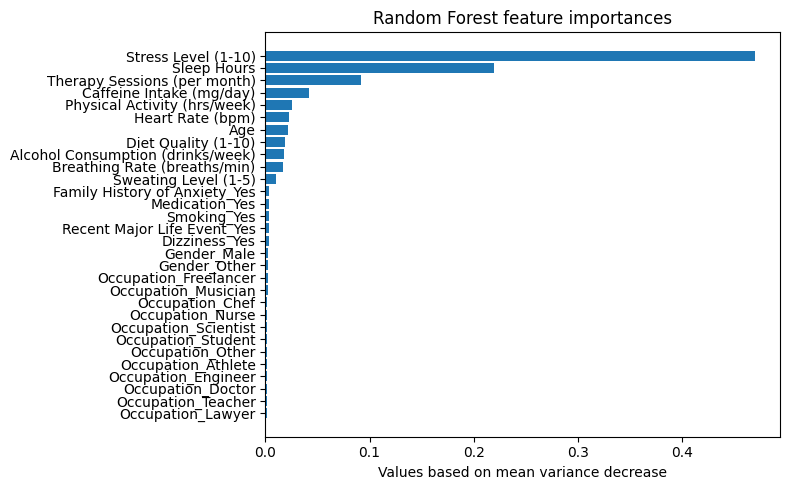

In [44]:
importances_rf = rf_model.feature_importances_   

# sort the features
features_unsorted = X_train_final.columns
sorted_idx = np.argsort(importances_rf)          
sorted_features = features_unsorted[sorted_idx]
importances_rf_sorted = importances_rf[sorted_idx]

# plot the feature importances
plt.figure(figsize=(8, 5))
plt.barh(sorted_features, importances_rf_sorted)
plt.xlabel("Values based on mean variance decrease")
plt.title("Random Forest feature importances")
plt.tight_layout()
plt.show()

In [43]:
rf_df = pd.DataFrame(data = importances_rf_sorted, index = sorted_features).iloc[::-1]
rf_df

,0
Stress Level (1-10),0.470756
Sleep Hours,0.219743
Therapy Sessions (per month),0.092093
Caffeine Intake (mg/day),0.042226
Physical Activity (hrs/week),0.025243
Heart Rate (bpm),0.022672
Age,0.021564
Diet Quality (1-10),0.019159
Alcohol Consumption (drinks/week),0.017501
Breathing Rate (breaths/min),0.017163


Based on the feature importance, the most useful predictors are 

## XGBoost

In [27]:
# instantiate the model
xgb_model = XGBRegressor(
                        n_estimators=100,
                        learning_rate=0.1,
                        max_depth=4,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=13,
                        n_jobs=-1
                        )

# fit the model
xgb_model.fit(X_train_final, y_train)

# predict on train and test sets
y_train_pred_xgb = xgb_model.predict(X_train_final)
y_test_pred_xgb = xgb_model.predict(X_test_final)

# evaluate on train and test sets
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

# print the results
print(f"XGBoost Results:")
print(f"Train RMSE: {rmse_train_xgb:.2f} | R²: {r2_train_xgb:.4f}")
print(f"Test  RMSE: {rmse_test_xgb:.2f} | R²: {r2_test_xgb:.4f}")

XGBoost Results:
Train RMSE: 0.94 | R²: 0.8046
Test  RMSE: 1.02 | R²: 0.7709


In [ ]:
# feature importance for XGBoost
importances_xgb = xgb_model.feature_importances_  # # get the Gini decrease

# sorting the features
features_unsorted_xgb = X_train_final.columns
sorted_idx_xgb = np.argsort(importances_xgb)        # returns the indices that would sort the array importances_rf in ascending order
sorted_features_xgb = features_unsorted_xgb[sorted_idx_xgb]
importances_xgb_sorted = importances_xgb[sorted_idx_xgb]

# plot
plt.figure(figsize=(8, 5))
plt.barh(sorted_features_xgb, importances_xgb_sorted)  # use sorted labels
plt.xlabel("Importance (Gini-based)")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()